In [3]:
from kneed import DataGenerator, KneeLocator
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os
import scipy.io
import math
from utils import *
import glob
from scipy import stats

In [4]:
t_pre = 0.2#0.2
t_post = 0.50#0.300
bin_width = 0.005
# Créer les bins de temps"
psth_bins = np.arange(-t_pre, t_post, bin_width)
#gc = np.arange(0, 32)

In [5]:
path = '/mnt/working2/felicie/data2/eTheremin/ALTAI/ALTAI_20240724_SESSION_01/'  

In [6]:
data = np.load(path+'headstage_0/data_0.005.npy', allow_pickle=True)
features = np.load(path+'headstage_0/features_0.005.npy', allow_pickle=True)
gc = np.load(path+'headstage_0/good_clusters.npy', allow_pickle=True)

In [12]:
features

array([{'Played_frequency': 0.0, 'Condition': 0.0, 'Frequency_changes': False},
       {'Played_frequency': 0.0, 'Condition': 0.0, 'Frequency_changes': False},
       {'Played_frequency': 0.0, 'Condition': 0.0, 'Frequency_changes': False},
       ...,
       {'Played_frequency': 715.0, 'Condition': 1.0, 'Frequency_changes': False},
       {'Played_frequency': 715.0, 'Condition': 1.0, 'Frequency_changes': False},
       {'Played_frequency': 715.0, 'Condition': 1.0, 'Frequency_changes': False}],
      dtype=object)

In [8]:
tail = get_psth(data, features, t_pre, t_post, bin_width, gc, 'tail')
tracking = get_psth(data, features, t_pre, t_post, bin_width, gc, 'tracking')
mc = get_psth(data, features, t_pre, t_post, bin_width, gc, 'mapping change')
playback = get_psth(data, features, t_pre, t_post, bin_width, gc, 'playback')

In [9]:
np.save(path+'headstage_0/psth_tracking_0.005.npy', tracking)
np.save(path+'headstage_0/psth_playback_0.005.npy', playback)
np.save(path+'headstage_0/psth_mappingchange_0.005.npy', mc) 
np.save(path+'headstage_0/psth_tail_0.005.npy', tail)

In [10]:
def get_plot_coords(channel_number):
    """
    Fonction qui calcule la position en 2D d'un canal sur une Microprobe.
    Retourne la ligne et la colonne.
    """
    if channel_number in list(range(8)):
        row = 3
        col = channel_number % 8

    elif channel_number in list(range(8, 16)):
        row = 1
        col = 7 - channel_number % 8

    elif channel_number in list(range(16, 24)):
        row = 0
        col = 7 - channel_number % 8

    else:
        row = 2
        col = channel_number % 8

    return row, col

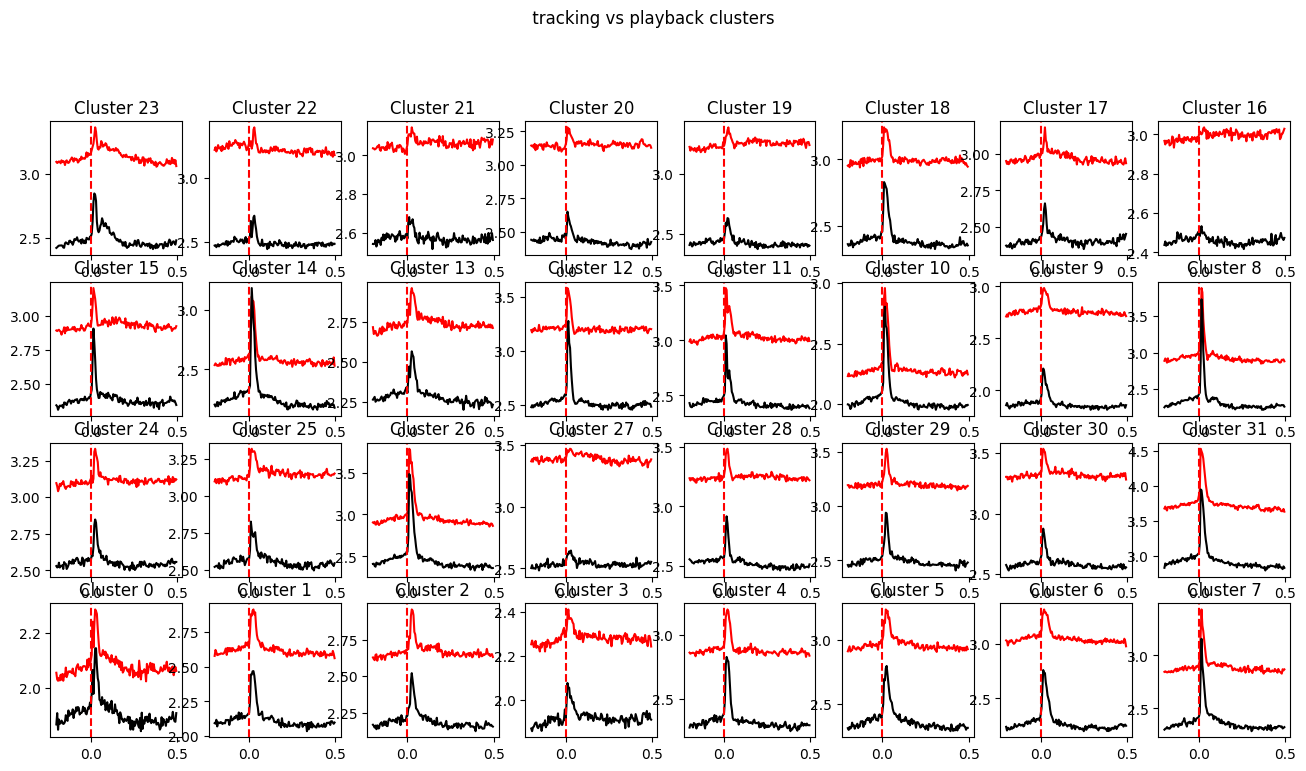

In [11]:
# pour plot cluster par cluster
num_plots, num_rows, num_columns = get_better_plot_geometry(gc)


fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle(' tracking vs playback clusters', y=1.02)
plt.subplots_adjust() 

for cluster in range(num_plots):
    if cluster < num_plots: 
        row, col = get_plot_coords(cluster)
        axes[row, col].plot(psth_bins, np.nanmean(tracking[cluster], axis=0), c = 'red')
        axes[row, col].plot(psth_bins, np.nanmean(playback[cluster], axis=0), c = 'black')
        axes[row, col].axvline(0, c = 'red', linestyle='--')
        axes[row, col].set_title(f'Cluster {cluster}')

Nombre de bins significatifs : 140
significative difference


Text(0, 0.5, '[spikes/s]')

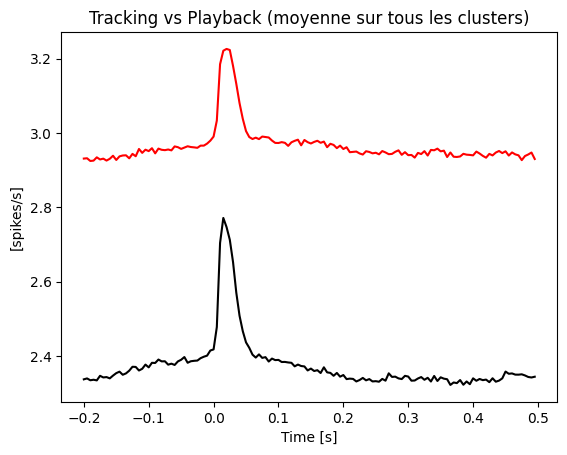

In [71]:
#plot tracking vs playbact_stat, p_value = stats.ttest_rel(avant, apres)k moyenné sur tous les clusters 
m_tracking = np.nanmean(tracking, axis=1)
tr = np.nanmean(m_tracking, axis=0)

m_playback = np.nanmean(playback, axis=1)
pb = np.nanmean(m_playback, axis=0)


# Calculer le test t pour chaque bin
t_stat, p_value = stats.ttest_rel(m_tracking, m_playback, axis=0)

# Interprétation globale
alpha = 0.05
significant_bins = p_value < alpha
print(f"Nombre de bins significatifs : {np.sum(significant_bins)}")
if np.sum(significant_bins)==140:
    print('significative difference')
else:
    print('no significative difference')
    


plt.plot(psth_bins, tr, c = 'red')
plt.plot(psth_bins, pb, c = 'black')
plt.title('Tracking vs Playback (moyenne sur tous les clusters)')
plt.xlabel('Time [s]')
plt.ylabel('[spikes/s]')



In [ ]:
# Comparer les psth en début de session et fin de session ou toutes les 5 min
 

In [76]:
# comparer le cas où le furet arrive de la droite ou de la gauche
indices_frequency_changes = []

# Parcourir le tableau et vérifier la condition
for i, item in enumerate(features):
    if item['Frequency_changes']:
        indices_frequency_changes.append(i)
        

indices_increase = []
indices_decrease = []

# Parcourir les indices pour diviser en deux groupes
for idx in indices_frequency_changes:
    # Vérifier si l'indice précédent existe
    if idx > 0:
        prev_played_freq = features[idx - 1]['Played_frequency']
        curr_played_freq = features[idx]['Played_frequency']
        
        if prev_played_freq < curr_played_freq:
            indices_increase.append(idx)
        elif prev_played_freq > curr_played_freq:
            indices_decrease.append(idx)


In [78]:
def get_psth_for_indexes(data, features, indexes, t_pre, t_post, bin_width, good_clusters, condition):
    """
    Pour voir, pour chaque neurone, les psth
    
    input: 
      -data, features, good_clustersn condition ("tracking" or "playback), indexes (les indices des bin qui nous intéressent)
    output : 
     - une liste contenant le psth moyen par cluster pour chaque changement de fréquence en playback [neurones x chgt de freq x [t_pre, t_post] ]
    """
    if condition=="tracking":
        c = 0
    elif condition == "playback" : 
        c=1
    elif condition== "tail":
        c = -1
    elif condition =="mapping change":
        c = 2
    
    
    psth=[] 
    for cluster in good_clusters:
        psth_clus = []
        for bin in indexes:
            #print(diff)
            if bin-int(t_pre/bin_width)>0 and bin+int(t_post/bin_width)<len(features):
                if features[bin]['Frequency_changes']>0 and features[bin]['Condition']==c :
                    psth_clus.append(data[cluster][bin-int(t_pre/bin_width):bin+int(t_post/bin_width)])
        psth.append(psth_clus)
    return psth

In [85]:
tr_decrease = get_psth_for_indexes(data, features, indices_decrease, t_pre, t_post, bin_width, gc, 'tracking')
tr_increase = get_psth_for_indexes(data, features, indices_increase, t_pre, t_post, bin_width, gc, 'tracking')
pb_decrease = get_psth_for_indexes(data, features, indices_decrease, t_pre, t_post, bin_width, gc, 'playback')
pb_increase = get_psth_for_indexes(data, features, indices_increase, t_pre, t_post, bin_width, gc, 'playback')

Nombre de bins significatifs : 121
no significative difference


Text(0, 0.5, '[spikes/s]')

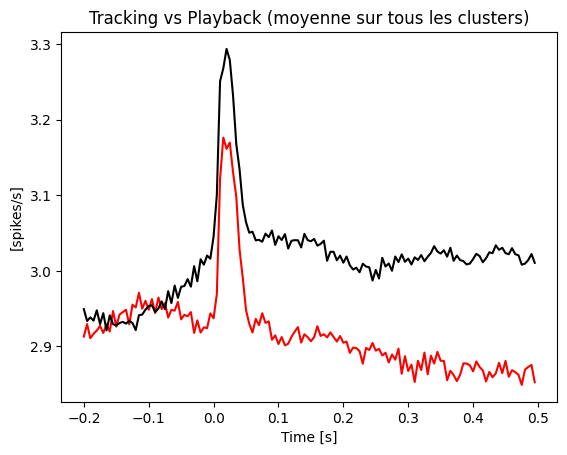